✅ Workflow Plan:
* Step 1: Load and explore the dataset.
* Step 2: Preprocessing + add <start> and <end> tokens.
* Step 3: Tokenization (with <OOV> handling).
* Step 4: Padding and sequence preparation.
* Step 5: Model 1 — Seq2Seq encoder-decoder model setup.
* Step 6: Training + loss plots.
* Step 7: Model 2 — Transformer-style seq2seq setup.
* Step 8: Training + loss plots.
* Step 9: Inference testing on unseen data.

## STEP 1: Load & Explore Dataset

---



In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import matplotlib.pyplot as plt

# Path to your dataset (adjust if needed)
file_path = '/content/drive/MyDrive/MT_Data/english-arabic-dataset.txt'

# Load first 10,000 lines
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()[:10000]

print(f"Total samples loaded: {len(lines)}")

Total samples loaded: 10000


In [24]:
# Separate English and Arabic sentences
eng_sentences = [str(line[0]) for line in lines]
arb_sentences = [str(line[1]) for line in lines]

for line in lines:
    try:
        eng, arb = line.strip().split('\t')
        eng_sentences.append(eng)
        arb_sentences.append(arb)
    except ValueError:
        continue
# Print 5 samples
for i in range(5):
    print(f"ENGLISH: {eng_sentences[i]}")
    print(f"ARABIC : {arb_sentences[i]}")
    print('---')

ENGLISH: H
ARABIC : i
---
ENGLISH: R
ARABIC : u
---
ENGLISH: H
ARABIC : e
---
ENGLISH: J
ARABIC : u
---
ENGLISH: S
ARABIC : t
---


In [25]:
# Sentence length analysis
eng_lengths = [len(sentence.split()) for sentence in eng_sentences]
arb_lengths = [len(sentence.split()) for sentence in arb_sentences]

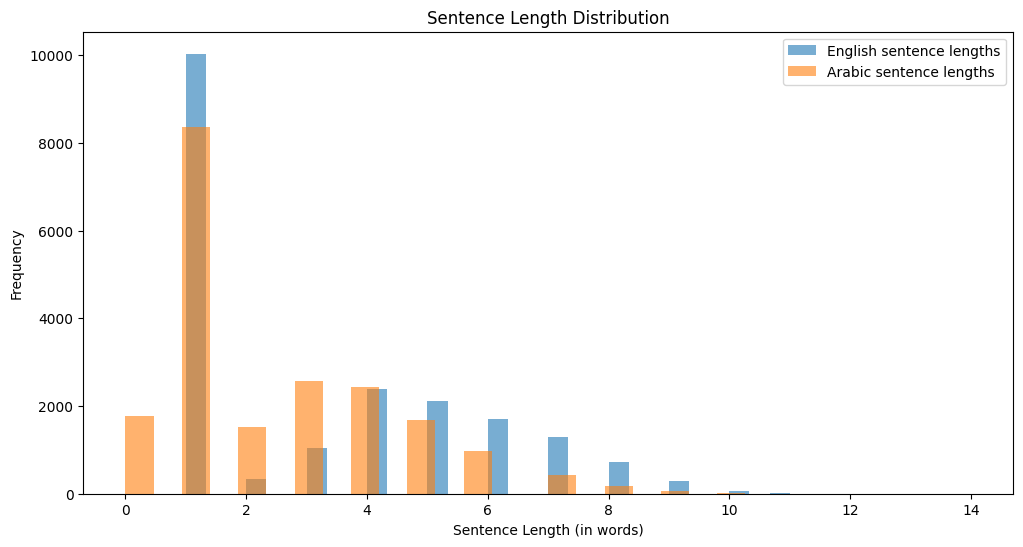

In [26]:
# Plot distributions
plt.figure(figsize=(12,6))
plt.hist(eng_lengths, bins=30, alpha=0.6, label='English sentence lengths')
plt.hist(arb_lengths, bins=30, alpha=0.6, label='Arabic sentence lengths')
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length (in words)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [27]:
# Check max lengths
print(f"Max English sentence length: {max(eng_lengths)}")
print(f"Max Arabic sentence length: {max(arb_lengths)}")

Max English sentence length: 11
Max Arabic sentence length: 14


## STEP 2: Preprocessing + Adding <start>, <end> Tokens

---


*   Lowercase
*   Strip whitespace
*   Remove punctuation
*   Remove digits if any
*   Remove double spaces
*   Start and end tokens added only on Arabic sentences.


In [28]:
# Function to clean and add special tokens
import re

def clean_sentence(sentence):
    # Lowercase
    sentence = sentence.lower().strip()
    # Remove punctuation and digits
    sentence = re.sub(r"[^a-zA-Zء-ي\s]", "", sentence)  # keeps Arabic & English letters and spaces only
    # Remove extra spaces
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence

def preprocess_arabic(sentence):
    sentence = clean_sentence(sentence)
    sentence = f"<start> {sentence} <end>"
    return sentence

def preprocess_english(sentence):
    sentence = clean_sentence(sentence)
    return sentence

# Apply cleaning
eng_sentences_cleaned = [preprocess_english(sent) for sent in eng_sentences]
arb_sentences_cleaned = [preprocess_arabic(sent) for sent in arb_sentences]

# Sanity check
for i in range(5):
    print(f"ENGLISH: {eng_sentences_cleaned[i]}")
    print(f"ARABIC : {arb_sentences_cleaned[i]}")
    print("---")

ENGLISH: h
ARABIC : <start> i <end>
---
ENGLISH: r
ARABIC : <start> u <end>
---
ENGLISH: h
ARABIC : <start> e <end>
---
ENGLISH: j
ARABIC : <start> u <end>
---
ENGLISH: s
ARABIC : <start> t <end>
---


## STEP 3: Tokenization with OOV handling and padding

---


In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# English tokenizer
eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
eng_tokenizer.fit_on_texts(eng_sentences_cleaned)
eng_tensor = eng_tokenizer.texts_to_sequences(eng_sentences_cleaned)
#eng_tensor = tf.keras.preprocessing.sequence.pad_sequences(eng_tensor, padding='post')
eng_tensor = tf.keras.preprocessing.sequence.pad_sequences(eng_tensor, padding='post')

# Arabic tokenizer
arb_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
arb_tokenizer.fit_on_texts(arb_sentences_cleaned)
arb_tensor = arb_tokenizer.texts_to_sequences(arb_sentences_cleaned)
#arb_tensor = tf.keras.preprocessing.sequence.pad_sequences(arb_tensor, padding='post')

# Pad the sequences to have a uniform shape before finding max length
arb_tensor = tf.keras.preprocessing.sequence.pad_sequences(arb_tensor, padding='post') # This line is modified

# Find max lengths
english_vocab_size = len(eng_tokenizer.word_index) + 1
arabic_vocab_size = len(arb_tokenizer.word_index) + 1
max_eng_len = eng_tensor.shape[1]
max_ar_len = arb_tensor.shape[1]

print(f"English vocab size: {english_vocab_size}")
print(f"Arabic vocab size: {arabic_vocab_size}")

English vocab size: 3601
Arabic vocab size: 8795


note : max length was 14 + 2 = 16

In [30]:
# Pad sequences
#eng_tensor = pad_sequences(eng_tensor, maxlen=max_eng_len, padding='post')
#arb_tensor = pad_sequences(arb_tensor, maxlen=max_ar_len, padding='post')

# Sanity check: print example
for i in range(3):
    print(f"English sequence: {eng_tensor[i]}")
    print(f"Arabic sequence: {arb_tensor[i]}")
    print("---")

print("Tokenization & padding step done bestie!")

English sequence: [10  0  0  0  0  0  0  0  0  0  0]
Arabic sequence: [ 2 25  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
---
English sequence: [361   0   0   0   0   0   0   0   0   0   0]
Arabic sequence: [ 2 58  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
---
English sequence: [10  0  0  0  0  0  0  0  0  0  0]
Arabic sequence: [2 6 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
---
Tokenization & padding step done bestie!


## STEP 4 : Prepare training and validation sets

---


### Data Split -  MADE 75%

In [31]:
from sklearn.model_selection import train_test_split

split_ratio = 0.75
split_index = int(len(eng_tensor) * split_ratio)

english_train, english_val = eng_tensor[:split_index], eng_tensor[split_index:]
arabic_train, arabic_val = arb_tensor[:split_index], arb_tensor[split_index:]

print(f"English train shape: {english_train.shape}")
print(f"English val shape: {english_val.shape}")
print(f"Arabic train shape: {arabic_train.shape}")
print(f"Arabic val shape: {arabic_val.shape}")


English train shape: (15000, 11)
English val shape: (5000, 11)
Arabic train shape: (15000, 16)
Arabic val shape: (5000, 16)


## Step 5: LSTM Seq2Seq Model


---



### Seq2Seq with RNN-based encoder-decoder

* Static LR = 0.0005

* Add ReduceLROnPlateau with factor=0.5, patience=3

* Add EarlyStopping with patience=5

* Train for max 50 epochs -- early stop/ just an upper limit  

* Batch size 64


2ND APPROACH
   
*   Add Dropout layers (with rates between 0.3–0.5)

* Add L2 weight regularization

* Use LearningRateScheduler to fine-tune

* Reduce batch size from 64 to something like 32

3RD AOOROACH

* Recurrent dropout & L2 regularization
* Reduced LSTM units
* Gradient clipping in the optimizer
* Learning rate scheduler callback


4RTH APROACH
* Try reducing LSTM AGAIN

* Stronger L2 regularization

* Dropout after embeddings

* Gaussian noise for extra regularization

* Early stopping with more patience

In [32]:
embedding_dim = 64
lstm_units = 128

In [33]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, GaussianNoise, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [34]:
def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  else:
    return lr * tf.math.exp(-0.1).numpy() # Convert Tensor to float using .numpy()
lr_scheduler = LearningRateScheduler(scheduler)

# Custom loss function that ignores padding (zeros)
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [35]:
from tensorflow.keras.layers import Masking

# Encoder
encoder_inputs = tf.keras.Input(shape=(None,))
encoder_embed = Embedding(english_vocab_size, embedding_dim)(encoder_inputs)
encoder_embed = Dropout(0.3)(encoder_embed)  # Add dropout after embeddings
encoder_lstm = LSTM(lstm_units, return_state=True, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(1e-4))
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embed)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = tf.keras.Input(shape=(None,))
decoder_embed = Embedding(arabic_vocab_size, embedding_dim)(decoder_inputs)
decoder_embed = Dropout(0.3)(decoder_embed)  # Dropout on decoder embeddings
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(1e-4))
decoder_outputs, _, _ = decoder_lstm(decoder_embed, initial_state=encoder_states)
decoder_dense = Dense(arabic_vocab_size, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [36]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=4, min_lr=1e-6)

In [37]:
# Prepare data for decoder
train_arb_in = arabic_train[:, :-1]
train_ar_out = arabic_train[:, 1:]
val_ar_in = arabic_val[:, :-1]
val_ar_out = arabic_val[:, 1:]

In [38]:
print(f"English train shape: {english_train.shape}")
print(f"English val shape: {english_val.shape}")
print(f"Arabic train input shape: {train_arb_in.shape}")
print(f"Arabic train output shape: {train_ar_out.shape}")

English train shape: (15000, 11)
English val shape: (5000, 11)
Arabic train input shape: (15000, 15)
Arabic train output shape: (15000, 15)


In [39]:
def predict_translation(input_sentence):
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_eng_len, padding='post')

    # Encode input
    states_value = encoder_model.predict(input_seq)  # Extract states from trained encoder

    # Decoder initial input
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = arb_tokenizer.word_index['<start>']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = arb_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_ar_len:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence

## STEP 6: Train LSTM Model

---



In [40]:
history = model.fit([english_train, train_arb_in], train_ar_out,
                    validation_data=([english_val, val_ar_in], val_ar_out),
                    batch_size=32, epochs=5, callbacks=[early_stop, reduce_lr])


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 95ms/step - accuracy: 0.8183 - loss: 3.3220 - val_accuracy: 0.6730 - val_loss: 3.0348 - learning_rate: 5.0000e-04
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.8975 - loss: 0.7938 - val_accuracy: 0.6764 - val_loss: 2.8052 - learning_rate: 5.0000e-04
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.9085 - loss: 0.6560 - val_accuracy: 0.6786 - val_loss: 2.7028 - learning_rate: 5.0000e-04
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.9089 - loss: 0.6119 - val_accuracy: 0.6801 - val_loss: 2.6753 - learning_rate: 5.0000e-04
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.9119 - loss: 0.5911 - val_accuracy: 0.6824 - val_loss: 2.6688 - learning_rate: 5.0000e-04


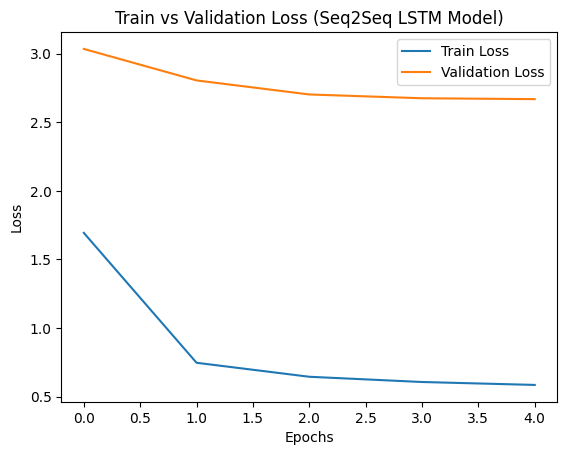

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss (Seq2Seq LSTM Model)')
plt.show()

# Model 2 — Transformer-style Seq2Seq Setup


---



---




## STEP 7: Transformer Model Functions


---







In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LayerNormalization, Dropout
import numpy as np

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [43]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


## STEP8: Build Transformer Model

---



In [45]:
# Model Parameters
embed_dim = 128  # Embedding size
num_heads = 8  # Number of attention heads
ff_dim = 512  # Feed forward layer size
max_len = 16  # Sentence max length (same as Seq2Seq model)

# Define Encoder
encoder_inputs = tf.keras.Input(shape=(None,))
embedding_layer = TokenAndPositionEmbedding(max_len, english_vocab_size, embed_dim)
x = embedding_layer(encoder_inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=False) # Pass training=False during model building
encoder_outputs = LayerNormalization(epsilon=1e-6)(x)

# Define Decoder
decoder_inputs = tf.keras.Input(shape=(None,))
decoder_embedding = TokenAndPositionEmbedding(max_len, arabic_vocab_size, embed_dim)
dec_x = decoder_embedding(decoder_inputs)
dec_x = transformer_block(dec_x, training=False) # Pass training=False here as well
decoder_outputs = Dense(arabic_vocab_size, activation="softmax")(dec_x)

# Define Full Transformer Model
transformer_model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
transformer_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
transformer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │      1,127,808 │ input_layer_7[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_1       │ (None, None, 128)      │        659,712 │ token_and_position_em… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, None, 8795)     │      1,134,555 │ transformer_block_1[1… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,922,075 (11.15 MB)

 Trainable params: 2,922,075 (11.15 MB)

 Non-trainable params: 0 (0.00 B)

##  Training the Transformer Seq2Seq Model

* Optimizer = Adam
* Loss = Sparse categorical crossentropy (matching integer-encoded targets)
* Trimmed decoder input + shifted decoder target setup
* Plots for visualizing training

In [46]:
# Training
train_ar_in = arabic_train[:, :-1]
train_ar_out = arabic_train[:, 1:]
val_ar_in = arabic_val[:, :-1]
val_ar_out = arabic_val[:, 1:]

history = transformer_model.fit(
    [english_train, train_ar_in], train_ar_out,
    validation_data=([english_val, val_ar_in], val_ar_out),
    batch_size=64, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.8501 - loss: 2.5739 - val_accuracy: 0.6919 - val_loss: 2.5364
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9391 - loss: 0.4411 - val_accuracy: 0.7309 - val_loss: 2.2740
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9543 - loss: 0.3077 - val_accuracy: 0.7471 - val_loss: 2.2193
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9665 - loss: 0.2130 - val_accuracy: 0.7815 - val_loss: 1.9412
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9801 - loss: 0.1327 - val_accuracy: 0.8082 - val_loss: 1.7538
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9897 - loss: 0.0743 - val_accuracy: 0.8310 - val_loss: 1.6497
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9962 - loss: 0.0409 - val_accuracy: 0.8453 - val_loss: 1.5796
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9996 - loss: 0.0192 - val_acc

## STEP 9:  Train Transformer Model

In [47]:
history_tf = transformer_model.fit([english_train, train_arb_in], train_ar_out,
                                   validation_data=([english_val, val_ar_in], val_ar_out),
                                   batch_size=64, epochs=20, callbacks=[early_stop, reduce_lr])

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 1.0000 - loss: 6.9527e-04 - val_accuracy: 0.8743 - val_loss: 1.4637 - learning_rate: 0.0010
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 1.0000 - loss: 5.5102e-04 - val_accuracy: 0.8748 - val_loss: 1.4686 - learning_rate: 0.0010
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 1.0000 - loss: 4.7839e-04 - val_accuracy: 0.8752 - val_loss: 1.4707 - learning_rate: 0.0010


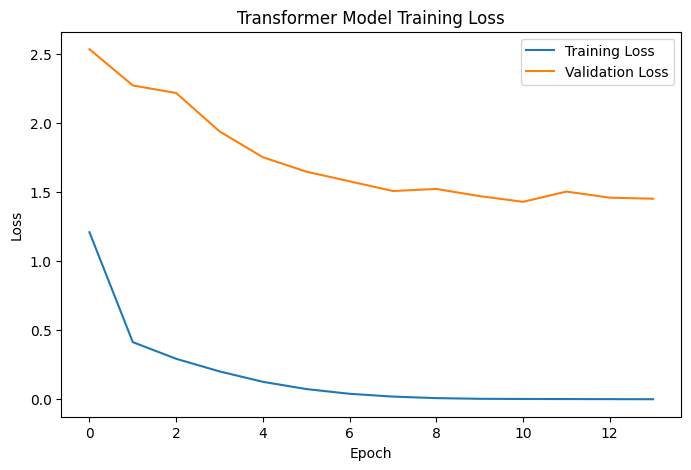

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## FINAL: Inference Testing on Unseen Data

---



---



In [56]:
test_sentences = [
    "How are you today?",
    "I love learning new things.",
    "What time is the meeting?",
    "This project was challenging and fun!",
    "You are amazing."
]

for sent in test_sentences:
    predict_translation(sent)


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m135157177905680\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 11), dtype=int32)\n  • training=False\n  • mask=None'